Goals for these graphs
- comparing the coverage of Congo to earlier publications (specifically earlier Arab Scribe, Cultural Yearbook, and Egyptian Economic and Political Review)
- comparing the coverage of Congo to the rest of the magazine in Arab Review and Arab Observer
- Ultimately argue that the increase in coverage was notable but also that Congo had a particular discourse in these publications

1. first identify words significant of algeria and yemen
- create tfidf models and normalize page lengths
- then subset out pages with highest weights in the model
2. use tf-idf and page similarities to look for change in language to create subset of most distinctive pages of coverage
- 
3. create model compared to rest of the magazine
4. compare to the rest of the magazines

In [ ]:
#import libraries

In [3]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import ast

In [6]:
#import data

Datasets:
National Publications House
- Arab Observer 1960-1963
- The Scribe 1961-1964
- Arab Review 1960-1963

---
Egyptian Periodicals
- Egyptian Economic and Political Review 1954-1962

---
AAPSO Periodicals
- Afro-Asian Bulletin 1961-1967 (English edition)
- Afro-Asian Bulletin 1961-1967 (Arabic edition)

---
African American Periodicals
- Liberator 1961-1971
- Freedomways 1961-1985

In [ ]:
# # 1. Arab Observer 1960-1963
arabobserver_df = pd.read_csv('../data/arab_observer_corpus_cleaned.csv')

arabobserver_df.datetime = pd.to_datetime(arabobserver_df['date'], format='%Y-%B-%d', errors='coerce')
# # ArabObserver_1960_61 = ArabObserver_df[ArabObserver_df.datetime < '1962-01-01']
arabobserver_df['page_date'] = arabobserver_df.date.astype(str)+'_'+arabobserver_df.page_number.astype(str)
arabobserver_df.dropna(subset=['cleaned_spacy_text'], inplace=True)

In [320]:

ao_docs_tfidf = pd.read_csv('../data/ao_algeria_unigram_training2.csv')

algeria_training_data = get_tfidf_weights(ao_docs_tfidf, algeria_df)
algeria_training_data.dropna(subset=['sum_weights'], inplace=True)

In [323]:
no_algeria = arabobserver_df.loc[arabobserver_df.cleaned_spacy_text.str.contains('algeria') == False]
sample_corpus = no_algeria.groupby(['date', 'binned'])
training_corpus = sample_corpus.apply(lambda x: x.sample(frac=0.04)).reset_index(drop=True)
len(training_corpus), len(algeria_training_data)

(374, 372)

In [324]:
training_corpus['classify'] = 'no_algeria'
algeria_training_data['classify'] = 'algeria'
training = pd.concat([algeria_training_data, training_corpus])
training.to_csv('../data/algeria_full_corpus_training2.csv')

In [315]:

yemen_docs_tfidf = pd.read_csv('../data/ao_yemen_unigram_training2.csv')

yemen_training_data = get_tfidf_weights(yemen_docs_tfidf, yemen_df)
yemen_training_data.dropna(subset=['sum_weights'], inplace=True)

In [318]:
no_yemen = arabobserver_df.loc[arabobserver_df.cleaned_spacy_text.str.contains('yemen') == False]
sample_corpus1 = no_yemen.groupby(['date', 'binned'])
training_corpus1 = sample_corpus1.apply(lambda x: x.sample(frac=0.015)).reset_index(drop=True)
len(training_corpus1), len(yemen_training_data)

(236, 209)

In [319]:
training_corpus1['classify'] = 'no_yemen'
yemen_training_data['classify'] = 'yemen'
training1 = pd.concat([yemen_training_data, training_corpus1])
training1.to_csv('../data/yemen_full_corpus_training2.csv')

In [325]:
congo_df = arabobserver_df.loc
# [arabobserver_df.date < '1962-01-01']
congo_df = congo_df.loc[congo_df.cleaned_spacy_text.str.contains('congo|belgrade')]

congo_docs_tfidf = pd.read_csv('../data/ao_congo_unigram_training2.csv')

congo_training_data = get_tfidf_weights(congo_docs_tfidf, congo_df)
congo_training_data.dropna(subset=['sum_weights'], inplace=True)

In [326]:
no_congo = arabobserver_df.loc
# [arabobserver_df.date < '1962-01-01']
no_congo = no_congo[no_congo.cleaned_spacy_text.str.contains('congo|belgrade') == False]
sample_corpus = no_congo.groupby(['date', 'binned'])
training_corpus = sample_corpus.apply(lambda x: x.sample(frac=0.25)).reset_index(drop=True)
len(training_corpus), len(congo_training_data)

(387, 366)

In [327]:
training_corpus['classify'] = 'no_congo'
congo_training_data['classify'] = 'congo'
training = pd.concat([congo_training_data, training_corpus])
training.to_csv('../data/congo_full_corpus_training2.csv')

In [5]:

import ptitprince as pt
import matplotlib.collections as clt
def make_prediction_curve(classified, pub_name):
    dy="prediction"; dx="abs_change_0"; pal = sns.color_palette('colorblind'); df=classified; ort="h"
#     .loc[classified.abs_change_0 > classified.abs_change_0.median()]

    sns.set(style="whitegrid")
    # sns.set(rc={'figure.figsize':(8.7,8.27)}, style="whitegrid")
    f, ax = plt.subplots(figsize=(8, 6))
    ax = pt.half_violinplot( x = dx, y = dy, data = df, palette = pal, bw = .2, cut = 0.,scale = "area", width = .6, inner = None, order=[ "algeria", "no_algeria"])
    ax=sns.stripplot( x = dx, y = dy, data = df, palette = pal, edgecolor = "white",size = 3, jitter = 1, zorder = 0, order=["algeria", "no_algeria"])
    ax=sns.boxplot(data=df, color="black",orient=ort,width=.15,x=dx,y=dy,zorder=10,showcaps=True,boxprops={'facecolor':'none', "zorder":10},showfliers=True,whiskerprops={'linewidth':2, "zorder":10},saturation=1)

    # ax = sns.violinplot(x="prediction", y="abs_change_0", inner=None, color=".8", data=congo_classified.loc[congo_classified.abs_change_0 > 0.1])

    # #  ax = sns.violinplot(x="day", y="total_bill", data=tips,
    # # ...                     inner=None, color=".8")
    # ax = sns.stripplot(x="prediction", y="abs_change_0", data=congo_classified.loc[congo_classified.abs_change_0 > 0.1], jitter=True)

    # ax.set_size_inches(15,15)
    # axes = g.axes.flatten()
    ax.set_title('Distribution of top predictions for {}'.format(pub_name))
    ax.set_ylabel('')
    ax.set_xlabel('absolute change from decision boundary')
    # ax.figure.savefig('the_review_raincloud_plot.png')
    return ax

In [343]:
def make_prediction_curve_grouped(classified, feature, group_name, boxplot,color_range, save, save_title):
    pl=["firebrick", "steelblue", "olive", "darkorchid", "goldenrod", "darkturquoise", "salmon", "darkslategray"]
    dy=feature; dx="abs_change_0"; pal = sns.color_palette(pl[color_range[0]:color_range[1]]); df=classified; ort="h"
#     .loc[classified.abs_change_0 > classified.abs_change_0.median()]

    sns.set(style="whitegrid")
    # sns.set(rc={'figure.figsize':(8.7,8.27)}, style="whitegrid")
    f, ax = plt.subplots(figsize=(8, 12))
    ax = pt.half_violinplot( x = dx, y = dy, data = df, palette = pal, bw = .2, cut = 0.,scale = "area", width = .6, inner = None, order=classified[feature].unique().tolist())
    ax=sns.stripplot( x = dx, y = dy, data = df, palette = pal, edgecolor = "white",size = 3, jitter = 1, zorder = 0, order=classified[feature].unique().tolist())
    if boxplot:
        ax=sns.boxplot(data=df, color="black",orient=ort,width=.15,x=dx,y=dy,zorder=10,showcaps=True,boxprops= {'facecolor':'none', "zorder":10},showfliers=True,whiskerprops={'linewidth':2,"zorder":10},saturation=1)

    # ax = sns.violinplot(x="prediction", y="abs_change_0", inner=None, color=".8", data=congo_classified.loc[congo_classified.abs_change_0 > 0.1])

    # #  ax = sns.violinplot(x="day", y="total_bill", data=tips,
    # # ...                     inner=None, color=".8")
    # ax = sns.stripplot(x="prediction", y="abs_change_0", data=congo_classified.loc[congo_classified.abs_change_0 > 0.1], jitter=True)

    # ax.set_size_inches(15,15)
    # axes = g.axes.flatten()
    ax.set_title('Distribution of top predictions for {}'.format(group_name))
    ax.set_ylabel('')
    ax.set_xlabel('absolute change from decision boundary')
    # ax.figure.savefig('the_review_raincloud_plot.png')
    if save:
        ax.figure.savefig(save_title, dpi = 300)
    return ax

In [51]:

ao_models = [
    '../data/chap4_congo_classifier2_classified_corpus.csv',
    '../data/chap4_yemen_classifier2_classified_corpus.csv',
    '../data/chap4_algeria_classifier2_classified_corpus.csv',
]

algeria_models = [
    '../data/Freedomways_Scraped_1961_1985_ao_algeria2__classified_corpus.csv',
    '../data/Liberator_1961_1971_ao_algeria2__classified_corpus.csv',
    '../data/afro_asian_and_world_affairs_1964_1967_ao_algeria2__classified_corpus.csv',
    '../data/Afro_Asian_Bulletin_1961_1967_ao_algeria2__classified_corpus.csv',
    '../data/Egyptian_Economic_and_Political_Review_1954_1962_ao_algeria2__classified_corpus.csv',
    '../data/arab_world_1955_1972_ao_algeria2__classified_corpus.csv',
    
    '../data/Arab_Review_1960_1963_ao_algeria2__classified_corpus.csv',
    '../data/the_scribe_1961_1965_ao_algeria2__classified_corpus.csv',


]
yemen_models = [
    '../data/Freedomways_Scraped_1961_1985_ao_yemen2__classified_corpus.csv',
    '../data/Liberator_1961_1971_ao_yemen2__classified_corpus.csv',
    '../data/Afro_Asian_Bulletin_1961_1967_ao_yemen2__classified_corpus.csv',
    '../data/afro_asian_and_world_affairs_1964_1967_ao_yemen2__classified_corpus.csv',
    '../data/arab_world_1955_1972_ao_yemen2__classified_corpus.csv',
    '../data/Egyptian_Economic_and_Political_Review_1954_1962_ao_yemen2__classified_corpus.csv',
    '../data/Arab_Review_1960_1963_ao_yemen2__classified_corpus.csv',

    '../data/the_scribe_1961_1965_ao_yemen2__classified_corpus.csv',
    

]
congo_models = [
    '../data/Freedomways_Scraped_1961_1985_ao_congo2__classified_corpus.csv',
    '../data/Liberator_1961_1971_ao_congo2__classified_corpus.csv',
    '../data/Afro_Asian_Bulletin_1961_1967_ao_congo2__classified_corpus.csv',
    '../data/afro_asian_and_world_affairs_1964_1967_ao_congo2__classified_corpus.csv',
    '../data/arab_world_1955_1972_ao_congo2__classified_corpus.csv',
    '../data/Egyptian_Economic_and_Political_Review_1954_1962_ao_congo2__classified_corpus.csv',
    '../data/Arab_Review_1960_1963_ao_congo2__classified_corpus.csv',

    '../data/the_scribe_1961_1965_ao_congo2__classified_corpus.csv',
    

]

In [56]:
arab_world_df = pd.read_csv('../data/arab_world_1955_1972_volumes_processed.csv')
freedomways_df = pd.read_csv('../data/Freedomways_Scraped_1961_1985_all_issues_texts_cleaned.csv')
liberator_df = pd.read_csv('../data/Liberator_1961_1971_volumes_processed.csv')
ecopol_df = pd.read_csv('../data/Egyptian_Economic_and_Political_Review_1954_1962_volumes_processed.csv')
arab_review_df = pd.read_csv('../data/Arab_Review_1960_1963_volumes_processed.csv')
bull_df = pd.read_csv('../data/Afro_Asian_Bulletin_1961_1967_volumes_processed.csv')
scribe_df = pd.read_csv('../data/the_scribe_1961_1965_volumes_processed.csv')
afro_asianand_world_affairs_df = pd.read_csv('../data/afro_asian_and_world_affairs_1964_1967_volumes_processed.csv')


In [19]:
final_models_ao = []
for m in ao_models:
    classified = pd.read_csv(m)
    class_type = m.split('chap4_')[1].split('_')[0]
    print(class_type)
    
    classified.prediction[classified.prediction == 0] = class_type
    classified.prediction[classified.prediction == 1] = 'no_' + class_type
    classified['abs_change_0'] = 0.5 - classified.prediction_proba_0
    classified['abs_change_0'] = classified.abs_change_0.abs()
#     pub_name = ' '.join(m.split('/')[-1].split('classifier2')[0].split('_'))
#     if 'Freedomways' in m:
#         classified['date'] = classified.year.astype(str)+'-'+classified.month.astype(str)+'-'+classified.day.astype(str)
#         classified['page_date'] = classified.date.astype(str)+'_'+classified.page_number.astype(str)
#         cl = classified[['abs_change_0', 'prediction', 'page_number']]
#         cl.rename(columns={'page_number': 'page'}, inplace=True)
#     else:

#         classified['page_date'] = classified.dates.astype(str)+'_'+classified.page.astype(str)

#     cl = classified[['abs_change_0', 'prediction', 'page_number']]
#     cl['pub_name'] = pub_name
#     pub_names_algeria.append(pub_name)
    final_models_ao.append(classified)
finals_ao = pd.concat(final_models_ao)

congo
yemen
algeria


In [54]:
final_models_algeria = []
pub_names_algeria = []
for m in algeria_models:
    classified = pd.read_csv(m)
    #     print(classified.columns)
    classified.prediction[classified.prediction == 0] = 'algeria'
    classified.prediction[classified.prediction == 1] = 'no_algeria'
    classified['abs_change_0'] = 0.5 - classified.prediction_proba_0
    classified['abs_change_0'] = classified.abs_change_0.abs()
    pub_name = ' '.join(m.split('/')[-1].split('ao_algeria')[0].split('_'))
    if 'Freedomways' in m:
        classified['date'] = classified.year.astype(str)+'-'+classified.month.astype(str)+'-'+classified.day.astype(str)
        classified['page_date'] = classified.date.astype(str)+'_'+classified.page_number.astype(str)
        cl = classified[['abs_change_0', 'prediction', 'page_number']]
        cl.rename(columns={'page_number': 'page'}, inplace=True)
    else:

        classified['page_date'] = classified.dates.astype(str)+'_'+classified.page.astype(str)

        cl = classified[['abs_change_0', 'prediction', 'page']]
    cl['pub_name'] = pub_name
    pub_names_algeria.append(pub_name)
    final_models_algeria.append(cl)
finals_algeria = pd.concat(final_models_algeria)

In [166]:
x = len(finals_algeria[(finals_algeria.pub_name.str.contains('Freedomways')) & (finals_algeria.prediction == 'algeria')])

139

In [157]:
x = len(finals_yemen[(finals_yemen.pub_name.str.contains('asian')) & (finals_yemen.prediction == 'yemen')])

In [1]:
z = finals_algeria[(finals_algeria.pub_name.str.contains('Freedomways')) & (finals_algeria.prediction == 'algeria')]
z.sort_values('abs_change_0', ascending=False)

In [2]:
g = finals_congo[(finals_congo.pub_name.str.contains('Freedomways')) & (finals_congo.prediction == 'no_congo')]
g.sort_values('abs_change_0', ascending=False)[0:20]

In [70]:
final_models_yemen = []
for m in yemen_models:
    classified = pd.read_csv(m)
    #     print(classified.columns)
    classified.prediction[classified.prediction == 0] = 'yemen'
    classified.prediction[classified.prediction == 1] = 'no_yemen'
    classified['abs_change_0'] = 0.5 - classified.prediction_proba_0
    classified['abs_change_0'] = classified.abs_change_0.abs()
    pub_name = ' '.join(m.split('/')[-1].split('ao_yemen')[0].split('_'))
    if 'Freedomways' in m:
        classified['date'] = classified.year.astype(str)+'-'+classified.month.astype(str)+'-'+classified.day.astype(str)
        classified['page_date'] = classified.date.astype(str)+'_'+classified.page_number.astype(str)
        cl = classified[['abs_change_0', 'prediction', 'page_number']]
        cl.rename(columns={'page_number': 'page'}, inplace=True)
    else:

        classified['page_date'] = classified.dates.astype(str)+'_'+classified.page.astype(str)

        cl = classified[['abs_change_0', 'prediction', 'page']]
    cl['pub_name'] = pub_name
    final_models_yemen.append(cl)
finals_yemen = pd.concat(final_models_yemen)

In [71]:
final_models_congo = []
for m in congo_models:
    classified = pd.read_csv(m)
    #     print(classified.columns)
    classified.prediction[classified.prediction == 0] = 'congo'
    classified.prediction[classified.prediction == 1] = 'no_congo'
    classified['abs_change_0'] = 0.5 - classified.prediction_proba_0
    classified['abs_change_0'] = classified.abs_change_0.abs()
    pub_name = ' '.join(m.split('/')[-1].split('ao_yemen')[0].split('_'))
    if 'Freedomways' in m:
        classified['date'] = classified.year.astype(str)+'-'+classified.month.astype(str)+'-'+classified.day.astype(str)
        classified['page_date'] = classified.date.astype(str)+'_'+classified.page_number.astype(str)
        cl = classified[['abs_change_0', 'prediction', 'page_number']]
        cl.rename(columns={'page_number': 'page'}, inplace=True)
    else:

        classified['page_date'] = classified.dates.astype(str)+'_'+classified.page.astype(str)

        cl = classified[['abs_change_0', 'prediction', 'page']]
    cl['pub_name'] = pub_name
    final_models_congo.append(cl)
finals_congo = pd.concat(final_models_congo)

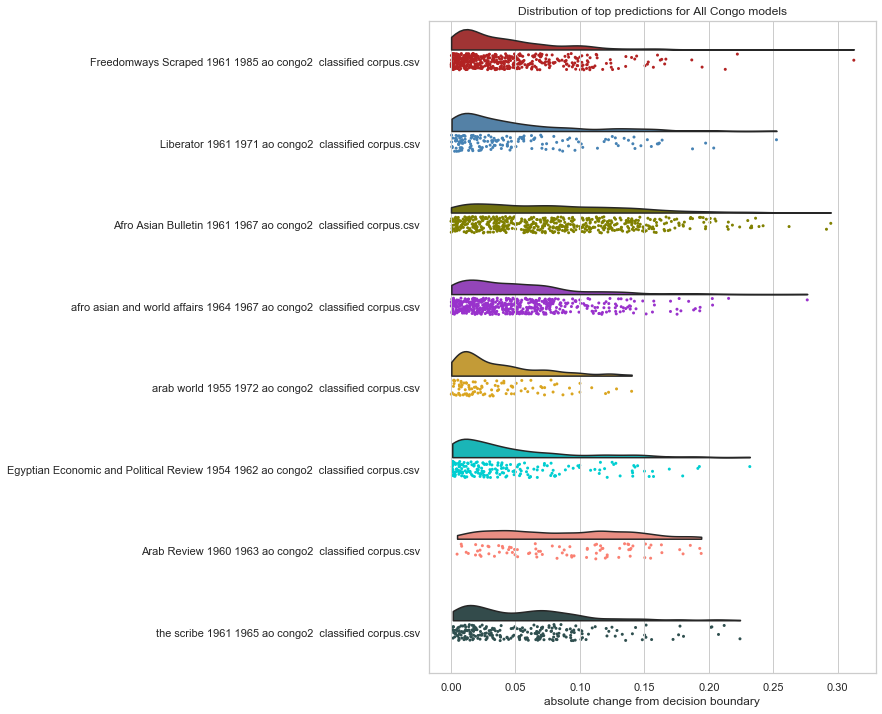

In [350]:
color_range = [0,9]
lib_free = finals_congo
x = make_prediction_curve_grouped(lib_free[(lib_free.prediction.str.contains('no') == False) ], 'pub_name', 'All Congo models', False, color_range, True, '../figures/all_congo_classifications.png')


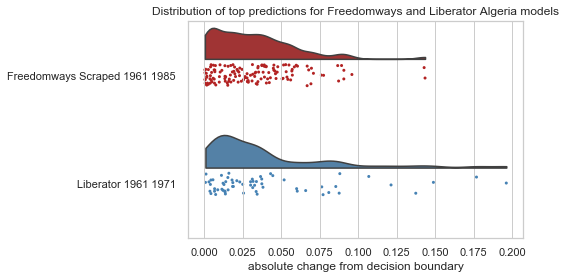

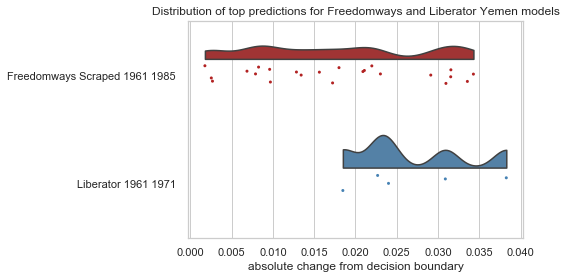

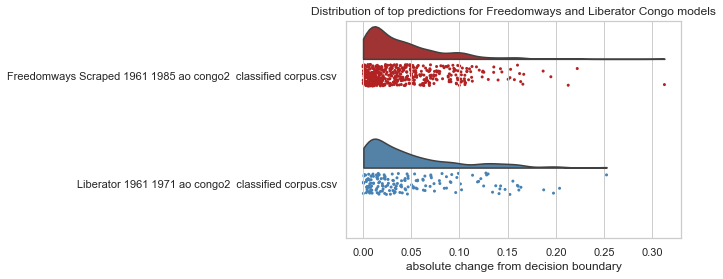

In [333]:
#Liberator and Freedomways algeria
color_range = [0,2]
lib_free = finals_algeria.loc[finals_algeria.pub_name.str.contains('Freedomways|Liberator')]
x = make_prediction_curve_grouped(lib_free[lib_free.prediction == 'algeria'], 'pub_name', 'Freedomways and Liberator Algeria models', False, color_range, False, '../figures/freedomways_liberator_algeria_classifications.png')

#Liberator and Freedomways yemen
color_range = [0,2]
lib_free = finals_yemen.loc[finals_yemen.pub_name.str.contains('Freedomways|Liberator')]
y = make_prediction_curve_grouped(lib_free[lib_free.prediction == 'yemen'], 'pub_name', 'Freedomways and Liberator Yemen models', False, color_range, False, '../figures/freedomways_liberator_yemen_classifications.png')

#Liberator and Freedomways congo
color_range = [0,2]
lib_free = finals_congo.loc[finals_congo.pub_name.str.contains('Freedomways|Liberator')]
y = make_prediction_curve_grouped(lib_free[lib_free.prediction == 'congo'], 'pub_name', 'Freedomways and Liberator Congo models', False, color_range, False, '../figures/freedomways_liberator_yemen_classifications.png')

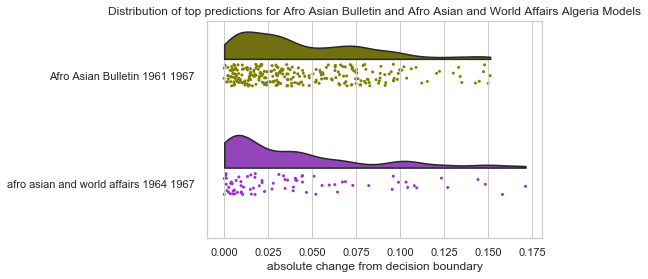

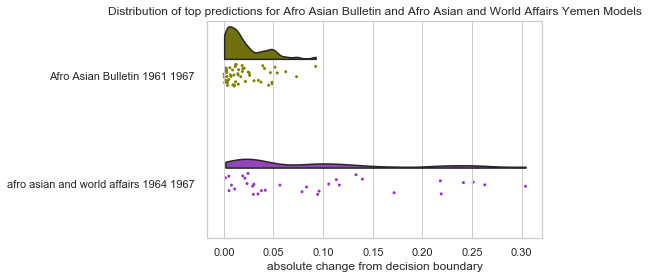

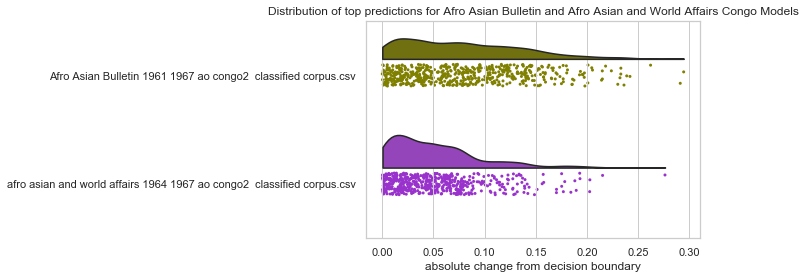

In [334]:
#Afro Asian women and Bulletin algeria
color_range = [2,5]
lib_free = finals_algeria.loc[finals_algeria.pub_name.str.contains('Bulletin|asian')]
lib_free.sort_values('pub_name', inplace=True)
x = make_prediction_curve_grouped(lib_free[lib_free.prediction == 'algeria'], 'pub_name', 'Afro Asian Bulletin and Afro Asian and World Affairs Algeria Models', False, color_range, False, '../figures/aabulletin_aaworldaffairs_algeria_classifications.png')

#Afro Asian women and Bulletin yemen
color_range = [2,5]
lib_free = finals_yemen.loc[finals_yemen.pub_name.str.contains('Bulletin|asian')]
lib_free.sort_values('pub_name', inplace=True)
y = make_prediction_curve_grouped(lib_free[lib_free.prediction == 'yemen'], 'pub_name', 'Afro Asian Bulletin and Afro Asian and World Affairs Yemen Models', False, color_range, False, '../figures/aabulletin_aaworldaffairs_yemen_classifications.png')

#Afro Asian women and Bulletin congo
color_range = [2,5]
lib_free = finals_congo.loc[finals_congo.pub_name.str.contains('Bulletin|asian')]
lib_free.sort_values('pub_name', inplace=True)
y = make_prediction_curve_grouped(lib_free[lib_free.prediction == 'congo'], 'pub_name', 'Afro Asian Bulletin and Afro Asian and World Affairs Congo Models', False, color_range, False, '../figures/aabulletin_aaworldaffairs_congo_classifications.png')

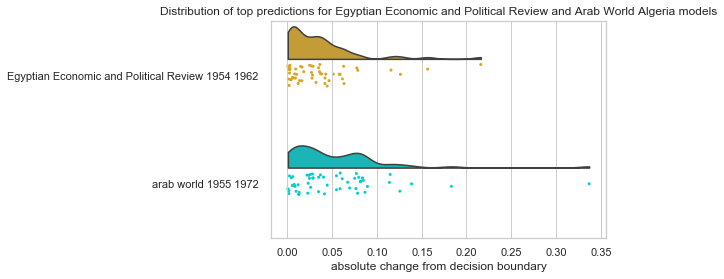

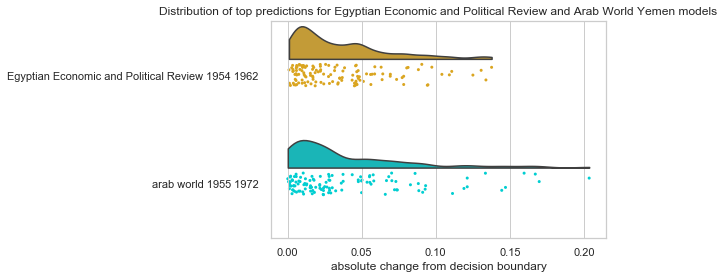

In [335]:
#Arab women and Bulletin algeria
color_range = [4,6]
lib_free = finals_algeria.loc[finals_algeria.pub_name.str.contains('1955|Economic')]
lib_free.sort_values('pub_name', inplace=True)
x = make_prediction_curve_grouped(lib_free[lib_free.prediction == 'algeria'], 'pub_name', 'Egyptian Economic and Political Review and Arab World Algeria models', False, color_range, False, '../figures/eepr_arabworld_algeria_classifications.png')

#Afro Asian women and Bulletin yemen
color_range = [4,6]
lib_free = finals_yemen.loc[finals_yemen.pub_name.str.contains('1955|Economic')]
lib_free.sort_values('pub_name', inplace=True)
y = make_prediction_curve_grouped(lib_free[lib_free.prediction == 'yemen'], 'pub_name', 'Egyptian Economic and Political Review and Arab World Yemen models', False, color_range, False, '../figures/eepr_arabworld_yemen_classifications.png')

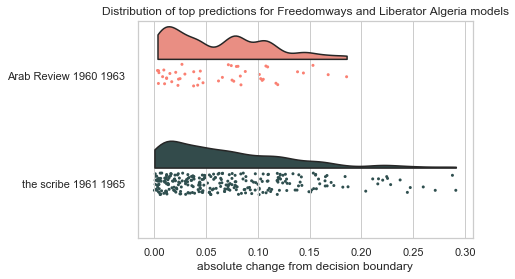

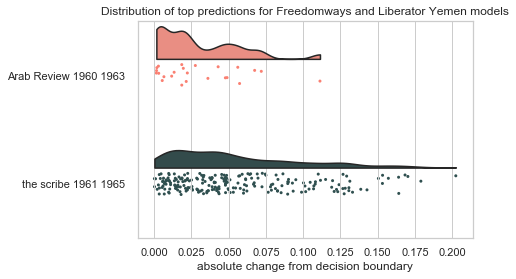

In [336]:
#Arab women and Bulletin algeria
color_range = [6,8]
lib_free = finals_algeria.loc[finals_algeria.pub_name.str.contains('Arab Review|scribe')]
x = make_prediction_curve_grouped(lib_free[lib_free.prediction == 'algeria'], 'pub_name', 'Freedomways and Liberator Algeria models', False, color_range, False, '../figures/eepr_arabworld_yemen_classifications.png')

#Afro Asian women and Bulletin yemen
color_range = [6,8]
lib_free = finals_yemen.loc[finals_yemen.pub_name.str.contains('Arab Review|scribe')]
y = make_prediction_curve_grouped(lib_free[lib_free.prediction == 'yemen'], 'pub_name', 'Freedomways and Liberator Yemen models', False, color_range, False, '../figures/eepr_arabworld_yemen_classifications.png')

In [13]:
def make_prediction_curve_publication(classified, feature, group_name, boxplot,save, save_title):
    pl=["crimson", "dodgerblue", "darkorange"]
    dy=feature; dx="abs_change_0"; pal = sns.color_palette(pl); df=classified; ort="h"
#     .loc[classified.abs_change_0 > classified.abs_change_0.median()]

    sns.set(style="whitegrid")
    # sns.set(rc={'figure.figsize':(8.7,8.27)}, style="whitegrid")
    f, ax = plt.subplots(figsize=(6, 4))
    ax = pt.half_violinplot( x = dx, y = dy, data = df, palette = pal, bw = .2, cut = 0.,scale = "area", width = .6, inner = None, order=classified[feature].unique().tolist())
    ax=sns.stripplot( x = dx, y = dy, data = df, palette = pal, edgecolor = "white",size = 3, jitter = 1, zorder = 0, order=classified[feature].unique().tolist())
    if boxplot:
        ax=sns.boxplot(data=df, color="black",orient=ort,width=.15,x=dx,y=dy,zorder=10,showcaps=True,boxprops= {'facecolor':'none', "zorder":10},showfliers=True,whiskerprops={'linewidth':2,"zorder":10},saturation=1)

    # ax = sns.violinplot(x="prediction", y="abs_change_0", inner=None, color=".8", data=congo_classified.loc[congo_classified.abs_change_0 > 0.1])

    # #  ax = sns.violinplot(x="day", y="total_bill", data=tips,
    # # ...                     inner=None, color=".8")
    # ax = sns.stripplot(x="prediction", y="abs_change_0", data=congo_classified.loc[congo_classified.abs_change_0 > 0.1], jitter=True)

    # ax.set_size_inches(15,15)
    # axes = g.axes.flatten()
    ax.set_title('Distribution of top predictions for {}'.format(group_name))
    ax.set_ylabel('')
    ax.set_xlabel('absolute change from decision boundary')
    # ax.figure.savefig('the_review_raincloud_plot.png')
    if save:
        ax.figure.savefig(save_title, dpi = 300)
    return ax

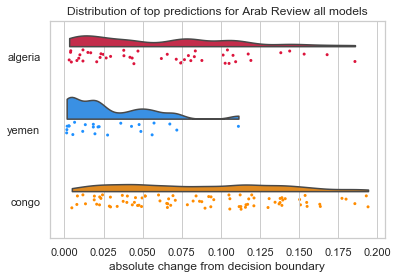

In [361]:
term = 'Arab Review'

freedomways = pd.concat([finals_algeria.loc[finals_algeria.pub_name.str.contains(term)],finals_yemen.loc[finals_yemen.pub_name.str.contains(term)],finals_congo.loc[finals_congo.pub_name.str.contains(term)]])
# freedomways.sort_values('prediction', inplace=True)
x = make_prediction_curve_publication(freedomways.loc[freedomways.prediction.str.contains('no') ==False], 'prediction', '{} all models'.format(term), False, True, '../figures/all_{}_classifications.png'.format(term))

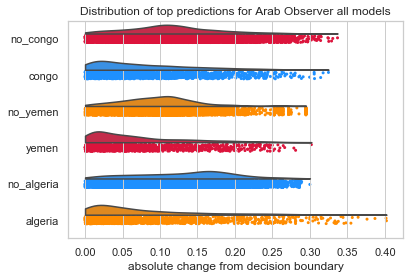

In [50]:
term = 'Arab Observer'

# freedomways = pd.concat([finals_algeria.loc[finals_algeria.pub_name.str.contains(term)],finals_yemen.loc[finals_yemen.pub_name.str.contains(term)],finals_congo.loc[finals_congo.pub_name.str.contains(term)]])
# freedomways.sort_values('prediction', inplace=True)
x = make_prediction_curve_publication(finals_ao, 'prediction', '{} all models'.format(term), False, False, '../figures/all_{}_classifications.png'.format(term))

In [363]:
x = finals_algeria.loc[finals_algeria.pub_name.str.contains('scribe')]
y = finals_algeria.loc[finals_algeria.pub_name.str.contains('asian')]

from scipy.stats import ks_2samp

ks_2samp(x.abs_change_0.to_numpy(), y.abs_change_0.to_numpy())

Ks_2sampResult(statistic=0.13818733857770943, pvalue=4.009087506418041e-10)

In [ ]:

final_models = []
for m in algeria_models[0:2]:
    classified = pd.read_csv(m)
    #     print(classified.columns)
    classified.prediction[classified.prediction == 0] = 'algeria'
    classified.prediction[classified.prediction == 1] = 'no_algeria'
    classified['abs_change_0'] = 0.5 - classified.prediction_proba_0
    classified['abs_change_0'] = classified.abs_change_0.abs()
    pub_name = ' '.join(m.split('/')[-1].split('ao_algeria')[0].split('_'))
    if 'Freedomways' in m:
        classified['date'] = classified.year.astype(str)+'-'+classified.month.astype(str)+'-'+classified.day.astype(str)
        classified['page_date'] = classified.date.astype(str)+'_'+classified.page_number.astype(str)
        cl = classified[['abs_change_0', 'prediction', 'page_number']]
        cl.rename(columns={'page_number': 'page'}, inplace=True)
    else:

        classified['page_date'] = classified.dates.astype(str)+'_'+classified.page.astype(str)

        cl = classified[['abs_change_0', 'prediction', 'page']]
    cl['pub_name'] = pub_name
    final_models.append(cl)
finals = pd.concat(final_models)

    #     print(len(classified), len(classified.loc[classified.abs_change_0 > classified.abs_change_0.median()]))

    #     print(leclassifiedss))
fig = make_prediction_curve(classified, pub_name)

In [ ]:
#Liberator and Freedomways
#     classified = pd.read_csv(m)
# #     print(classified.columns)
#     classified.prediction[classified.prediction == 0] = 'algeria'
#     classified.prediction[classified.prediction == 1] = 'no_algeria'
#     classified['abs_change_0'] = 0.5 - classified.prediction_proba_0
#     classified['abs_change_0'] = classified.abs_change_0.abs()
#     pub_name = ' '.join(m.split('/')[-1].split('ao_algeria')[0].split('_'))
#     if 'Freedomways' in m:
#         classified['date'] = classified.year.astype(str)+'-'+classified.month.astype(str)+'-'+classified.day.astype(str)
#         classified['page_date'] = classified.date.astype(str)+'_'+classified.page_number.astype(str)
#         cl = classified[['abs_change_0', 'prediction', 'page_number']]
#         cl.rename(columns={'page_number': 'page'}, inplace=True)
#     else:
        
#         classified['page_date'] = classified.dates.astype(str)+'_'+classified.page.astype(str)
    
#         cl = classified[['abs_change_0', 'prediction', 'page']]
#     cl['pub_name'] = pub_name
# #     final_models.append(cl)
# #     print(len(classified), len(classified.loc[classified.abs_change_0 > classified.abs_change_0.median()]))
    
# #     print(leclassifiedss))
#     fig = make_prediction_curve(classified, pub_name)

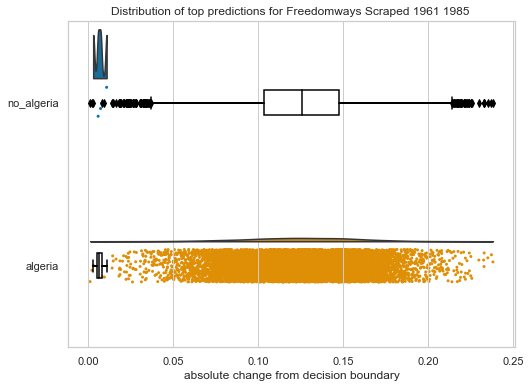

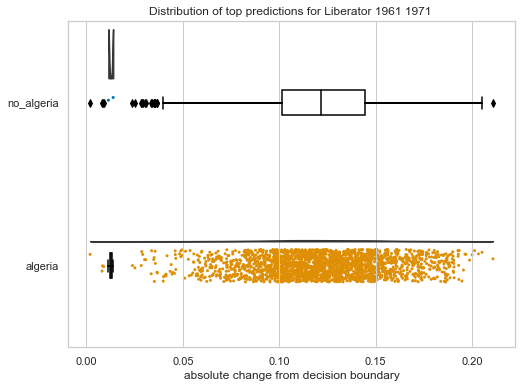

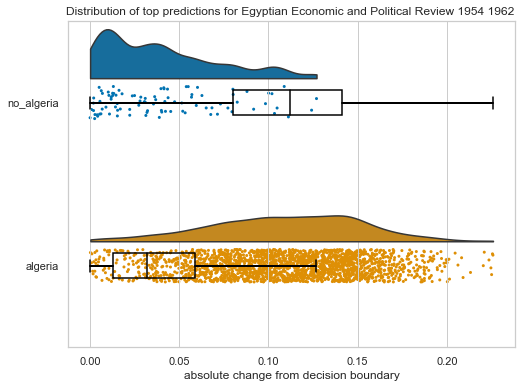

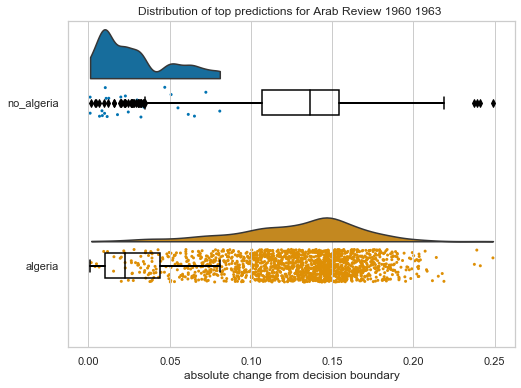

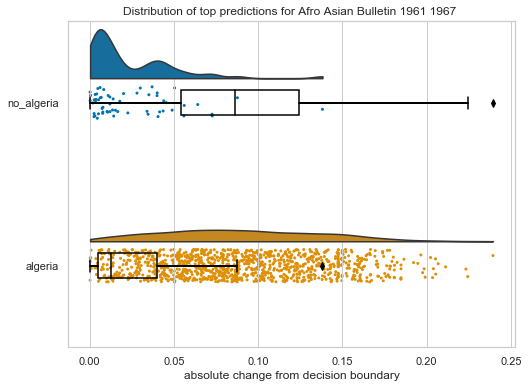

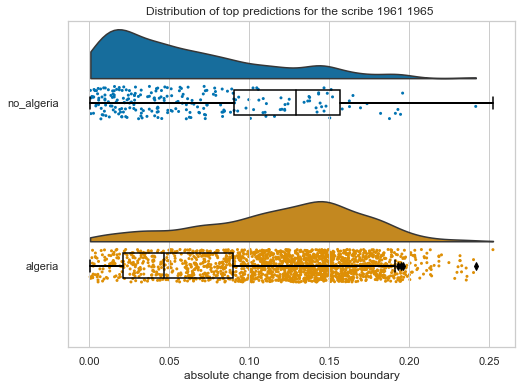

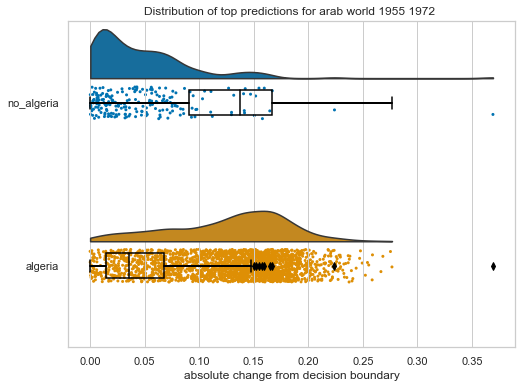

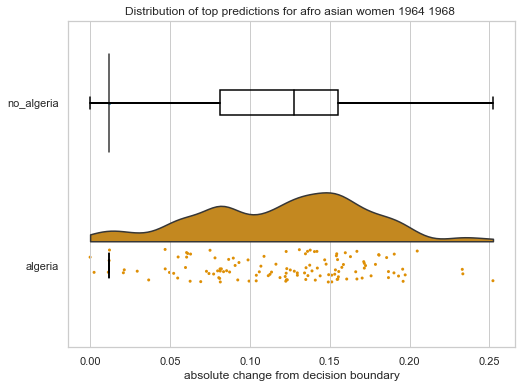

In [132]:

for m in models:
#     print(m)
    classified = pd.read_csv(m)
#     print(classified.columns)
    classified.prediction[classified.prediction == 0] = 'algeria'
    classified.prediction[classified.prediction == 1] = 'no_algeria'
    classified['abs_change_0'] = 0.5 - classified.prediction_proba_0
    classified['abs_change_0'] = classified.abs_change_0.abs()
    pub_name = ' '.join(m.split('/')[-1].split('ao_algeria')[0].split('_'))
    if 'Freedomways' in m:
        classified['date'] = classified.year.astype(str)+'-'+classified.month.astype(str)+'-'+classified.day.astype(str)
        classified['page_date'] = classified.date.astype(str)+'_'+classified.page_number.astype(str)
        cl = classified[['abs_change_0', 'prediction', 'page_number']]
        cl.rename(columns={'page_number': 'page'}, inplace=True)
    else:
        
        classified['page_date'] = classified.dates.astype(str)+'_'+classified.page.astype(str)
    
        cl = classified[['abs_change_0', 'prediction', 'page']]
    cl['pub_name'] = pub_name
#     final_models.append(cl)
#     print(len(classified), len(classified.loc[classified.abs_change_0 > classified.abs_change_0.median()]))
    
#     print(leclassifiedss))
    fig = make_prediction_curve(classified, pub_name)

In [8]:
ecopol = pd.read_csv('../data/Egyptian_Economic_and_Political_Review_1954_1962_congo_corpus.csv')
ecopol['date'] = ecopol.dates.str.split("_").str[-2:].str.join('-')
ecopol['page_date'] = ecopol.date.astype(str)+'_'+ecopol.page.astype(str)
ecopol['type'] = 'ecopol'
# arab_review_df
# alt.themes.enable('opaque')
# ep = alt.Chart(ecopol).mark_bar().encode(
#     x=alt.X('page_date:O',axis=alt.Axis(title='')),
#     y=alt.Y('sum(spacy_word_counts)',axis=alt.Axis(title='')),
#     color=alt.Color('date:O', scale=alt.Scale(scheme='plasma'))
# ).properties(
#     width=300,
#     height=200,
#     title='Frequency of Congo coverage in The Egyptian Economic and Political Review 1954-1962'
# ).configure_axisX(labelAngle=0, labels=False)
# ep
ecopol
# .save('ecopol.png', scale_factor=2.0)

,index,page,lowercase,cleaned_nltk_counts,cleaned_nltk_text,cleaned_spacy_counts,cleaned_spacy_text,dates,original_counts,original_text,title,vols,term,nltk_word_counts,spacy_word_counts,date,page_date,type
0,5,10,"'s 's 's 's 's ( ( , , , , , , , , , , , , , ,...",391,"'s 's 's 's 's 01 11,000 14 41 73 73 action ad...",383,action aden advance advance afghanistan africa...,and_political_review_v5_6_1958_1960,753.0,"'s 's 's 's 's ( ( , , , , , , , , , , , , , ,...",the_egyptian_economic,na,congo,1,1,1958-1960,1958-1960_10,ecopol
1,9,14,""" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ...",473,`` `` `` `` `` `` `` `` `` `` `` `` `` `` `` `...,434,abusive actually advancing advice advocates af...,and_political_review_v5_6_1958_1960,884.0,""" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ...",the_egyptian_economic,na,congo,1,1,1958-1960,1958-1960_14,ecopol
2,142,147,""" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""dissolve ""flood...",435,`` `` `` `` `` `` `` `` `` `` `` `` `` `` `` `...,407,dissolve flood international nether st address...,and_political_review_v5_6_1958_1960,773.0,""" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""dissolve ""flood...",the_egyptian_economic,na,congo,1,1,1958-1960,1958-1960_147,ecopol
3,217,222,"! "" ""increased % % ' ' ' ' ' ' ' ''a 's 's 's ...",505,`` `` increased `` 's 's 's figure -.. -buyers...,432,increased figure accommodating according accou...,and_political_review_v5_6_1958_1960,925.0,"! "" ""increased % % ' ' ' ' ' ' ' ''a 's 's 's ...",the_egyptian_economic,na,congo,2,2,1958-1960,1958-1960_222,ecopol
4,250,255,"! "" ""natives & , , , , , , , , , , , , , , , ,...",321,`` `` natives ... 1 11 18 1959-60 21 25 26 28 ...,299,natives accra achieving affairs africa africa ...,and_political_review_v5_6_1958_1960,617.0,"! "" ""natives & , , , , , , , , , , , , , , , ,...",the_egyptian_economic,na,congo,1,1,1958-1960,1958-1960_255,ecopol
5,269,274,""" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""before ""dis...",613,`` `` `` `` `` `` `` `` `` `` `` `` `` `` `` `...,564,distracting domination many material morality ...,and_political_review_v5_6_1958_1960,1327.0,""" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""before ""dis...",the_egyptian_economic,na,congo,1,1,1958-1960,1958-1960_274,ecopol
6,373,380,""" & ' ' '' 'es 's 's * * ** *\ , , , , , , , ,...",428,`` `` 'es 's 's ** *\ 0 1 1 1951 \wing adminis...,415,`` es 's 's administrative afcia afcx africa a...,and_political_review_v5_6_1958_1960,831.0,""" & ' ' '' 'es 's 's * * ** *\ , , , , , , , ,...",the_egyptian_economic,na,congo,6,6,1958-1960,1958-1960_380,ecopol
7,374,381,"! ! ! !j "" "" 'll 'ur , , , , , , , , , , , , ,...",280,j `` `` 'll 'ur ee -1-30 -40 -45 -• .ity /icle...,262,j ur ee e rse ter xperienced abdicated acceler...,and_political_review_v5_6_1958_1960,541.0,"! ! ! !j "" "" 'll 'ur , , , , , , , , , , , , ,...",the_egyptian_economic,na,congo,3,3,1958-1960,1958-1960_381,ecopol
8,438,445,"! & ' ' ' 'ese 'f 's 's 's 'unted , , , , , , ...",367,'ese f 's 's 's 'unted ... .6 12 14 18 20 25 2...,344,ese f unted mltism nthly able acceptance accep...,and_political_review_v5_6_1958_1960,687.0,"! & ' ' ' 'ese 'f 's 's 's 'unted , , , , , , ...",the_egyptian_economic,na,congo,7,7,1958-1960,1958-1960_445,ecopol
9,439,446,"! ! "" "" "" ""_ ' ' ' 'd 'mmanders 'nly 's 's 's ...",465,`` `` `` `` 'd 'mmanders 'nly 's 's 's 's 's '...,429,mmanders nly v able accomcdate accusation accu...,and_political_review_v5_6_1958_1960,883.0,"! ! "" "" "" ""_ ' ' ' 'd 'mmanders 'nly 's 's 's ...",the_egyptian_economic,na,congo,3,3,1958-1960,1958-1960_446,ecopol
